# 315 Bird Species - Classification

Dataset found on kaggle: [https://www.kaggle.com/gpiosenka/100-bird-species](https://www.kaggle.com/gpiosenka/100-bird-species)

## Getting the data

We can use the [opendatasets](https://github.com/jovianml/opendatasets) library to download the the dataset from kaggle.

In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

od.download('https://www.kaggle.com/gpiosenka/100-bird-species')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: s0mnaths
Your Kaggle Key: ··········


100%|██████████| 1.14G/1.14G [00:05<00:00, 214MB/s]


## Importing Libraries

In [5]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random

## Understanding the directory structure

In [6]:
data_dir = './100-bird-species'  

print(f'Directories: {os.listdir(data_dir)}')
classes = os.listdir(data_dir + "/train")
print(f'Number of classes: {len(classes)}')

Directories: ['valid', 'class_dict.csv', 'EfficientNetB3-birds-98.92.h5', 'test', 'one image to test', 'train', 'images to test']
Number of classes: 315


## Defining Transforms

In [7]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tfms = tt.Compose([tt.RandomCrop(224, padding=14, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])   
valid_tfms = tt.Compose([tt.ToTensor(),
                         tt.Normalize(*stats)])   

## Converting to PyTorch dataset format

In [8]:
train_ds = ImageFolder(data_dir+'/train', train_tfms) 
valid_ds = ImageFolder(data_dir+'/valid', valid_tfms) 
test_ds = ImageFolder(data_dir+'/test', valid_tfms) 

In [9]:
def dataset_info(dataset):
    print(f'Size fo dataset: {len(dataset)}')
    img, label = dataset[0]
    print(f'Sample-01 Image size: {img.shape}, Label: {label}')
    print(f'Number of classes: {len(dataset.classes)}\n\n')

print('Train Dataset\n-----------')
dataset_info(train_ds)
print('Validation Dataset\n-----------')
dataset_info(valid_ds)
print('Test Dataset\n-----------')
dataset_info(test_ds)

Train Dataset
-----------
Size fo dataset: 45980
Sample-01 Image size: torch.Size([3, 224, 224]), Label: 0
Number of classes: 315


Validation Dataset
-----------
Size fo dataset: 1575
Sample-01 Image size: torch.Size([3, 224, 224]), Label: 0
Number of classes: 315


Test Dataset
-----------
Size fo dataset: 1575
Sample-01 Image size: torch.Size([3, 224, 224]), Label: 0
Number of classes: 315




Each image is a torch tensor of size `3x224x224`

## Creating Dataloaders
Creating dataloader to load data in batches for training.

#### For reproducibility

In [10]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [11]:
batch_size = 256

set_seed(0)
train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2,  
                      pin_memory=True)  

set_seed(0)
valid_dl = DataLoader(valid_ds, 
                    batch_size*2,    # for validation we'll not compute gradients, so we'll need half the memory. Therefore we can double the batch size.
                    num_workers=2, 
                    pin_memory=True)


## Viewing a batch of dataset
We can look at batches of images from the dataset using the `make_grid` method from `torchvision`.

Since we have normalized the color channels, to view the images we'll first have to denormlize them.

In [12]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:100], nrow=10).permute(1, 2, 0).clamp(0,1))
        break

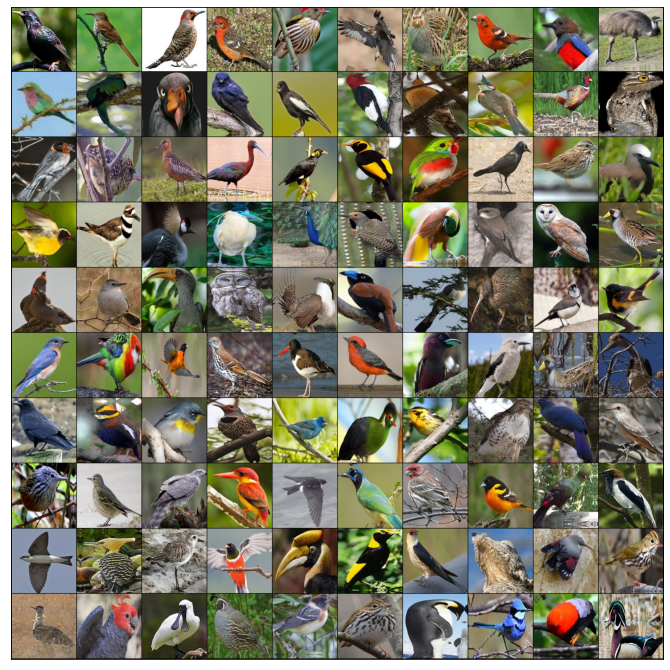

In [13]:
show_batch(train_dl)

## Defining the CNN model

We can define a Base class which will provide us with some helper functions for training and validation. We'll extend this base class to create the Model class.

In [14]:
class ClassificationBase(nn.Module):
    def training_step(self, batch):  
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            (epoch+1), result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Now extending this `ClassificationBase` to create the CNN

In [15]:
class WhatBirdie(ClassificationBase):
    def __init__(self):
        super().__init__()

        #input: 3 x 224 x 224
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(4, 4)
        self.res1 = nn.Sequential(
            nn.Conv2d(6, 6, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(6, 6, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.conv2 = nn.Conv2d(6, 32, kernel_size=3, padding=1)
        self.res2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.res3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.FConnected = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*7*7, 700),
            nn.ReLU(),
            nn.Linear(700, 700),
            nn.ReLU(),
            nn.Linear(700, 315)
        )
        
        
    def forward(self, xb):
        #input: 3 x 224 x 224
        out = F.relu(self.conv1(xb))   # output: 6 x 224 x224
        out = self.pool4(out)   # output: 6 x 56 x 56
        out = self.res1(out) + out   # output: 6 x 56 x 56
       
        out = F.relu(self.conv2(out))   # output: 32 x 56 x 56
        out = self.pool2(out)    # output: 32 x 28 x 28
        out = self.res2(out) + out   # output: 32 x 28 x 28
       
        out = F.relu(self.conv3(out))    # output: 64 x 28 x 28
        out = self.pool2(out)    # output: 64 x 14 x 14
        out = self.res3(out) + out    # output: 64 x 28 x 28
        
        out = F.relu(self.conv4(out))    # output: 128 x 14 x 14
        out = self.pool2(out)    # output: 128 x 7 x 7

        out = self.FConnected(out)   

        return out

## Moving our dataloader & model to device


In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)    # non-blocking indicates that the tensor will be moved to the GPU in a background thread

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
torch.cuda.empty_cache()

#### Using the above methods to move dataloader & model to device

In [19]:
# Instanciates & moves the model to GPU
model = to_device(WhatBirdie(), device)
set_seed(0)

# Moves the dataloader to GPU
train_dl = DeviceDataLoader(train_dl, device)
set_seed(0)
valid_dl = DeviceDataLoader(valid_dl, device)

## Training & Validation functions

In [20]:
@torch.no_grad()   
def evaluate(model, val_loader):
    model.eval()    
    outputs = [model.validation_step(batch) for batch in val_loader]    # validation loss & acc for each batch
    return model.validation_epoch_end(outputs)   # mean of validation loss & acc for each batch

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()    
        train_losses = []           # losses for each batch in an epoch
        for batch in train_loader:               # for each batch in the dataloader
            loss = model.training_step(batch)      # calc loss for each batch using the fn we defined earlier
            train_losses.append(loss)
            loss.backward()
            optimizer.step()        # perform gradient descent
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)    # validation loss & acc for that epoch
        result['train_loss'] = torch.stack(train_losses).mean().item()   # mean of training loss that we calculated batchwise
        model.epoch_end(epoch, result)   
        history.append(result)
    return history     # fit fn returns the training history of the model

Before training, let's see how it performs on validation set with inital parameters

In [21]:
evaluate(model, valid_dl)

{'val_acc': 0.00146484375, 'val_loss': 5.756350040435791}

## Set Training Hyperparameters

In [22]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

## Training the Model

In [23]:
%%time
history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

Epoch [1], train_loss: 5.1009, val_loss: 3.9374, val_acc: 0.1539
Epoch [2], train_loss: 3.6144, val_loss: 2.7076, val_acc: 0.3352
Epoch [3], train_loss: 2.7058, val_loss: 1.8160, val_acc: 0.5229
Epoch [4], train_loss: 2.1770, val_loss: 1.5258, val_acc: 0.6091
Epoch [5], train_loss: 1.7992, val_loss: 1.4060, val_acc: 0.6308
Epoch [6], train_loss: 1.5338, val_loss: 1.1465, val_acc: 0.6872
Epoch [7], train_loss: 1.3218, val_loss: 1.0503, val_acc: 0.7367
Epoch [8], train_loss: 1.1514, val_loss: 0.9134, val_acc: 0.7564
Epoch [9], train_loss: 1.0212, val_loss: 0.9267, val_acc: 0.7632
Epoch [10], train_loss: 0.9037, val_loss: 0.9259, val_acc: 0.7700
CPU times: user 2min 10s, sys: 1min 21s, total: 3min 31s
Wall time: 22min 39s


## Plot accuracy
Plot validation set accuracy

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

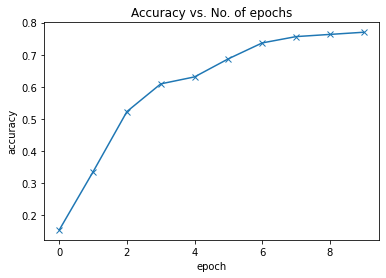

In [25]:
plot_accuracies(history)

## Plot Losses

Plot losses of training & validation set

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

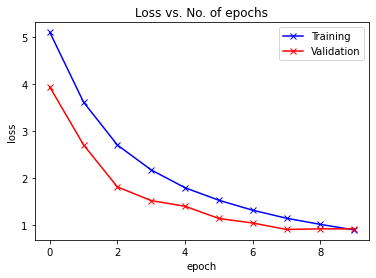

In [27]:
plot_losses(history)

We see that after epoch 6th, the `val_loss` started increasing a bit. This shows sign of overfitting. We should add some regularization techniques.

## Testing the model on the whole Test set

In [28]:
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_dl)
val_loss, val_acc = result.values()
print(f'Accuracy: {val_acc*100:.4f} %, Loss: {val_loss:.4f}')

Accuracy: 80.4738 %, Loss: 0.8214


## Saving the model

In [29]:
torch.save(model.state_dict(), 'WhatBirdies.pth')